In [89]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy as sp
import math
from sklearn.model_selection import train_test_split


In [90]:
# Set device and generic parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 250
batch_size = 10
split_size = 20

criterion = nn.MSELoss()
lr = 0.001

# Define the colors for each state (Assuming three states as before)
facies_colors = ['yellow', 'darkgoldenrod', 'grey']
facies_cmap = plt.cm.colors.ListedColormap(facies_colors)

In [91]:
# Initialize dictionaries to store latent spaces and loss histories
latent_spaces_noisy = {}
loss_histories = {}

In [92]:
# Define model dimensions and other parameters
model_height, model_width = 400, 400
minimum_thickness = 1
maximum_thickness = 10

In [93]:
def randomLayerModel(model_height, model_width, minimum_thickness, maximum_thickness):
    # Initialize impedance model
    impedance_model = np.zeros((model_height, model_width))
    
    # Initialize remaining vertical space in the model
    remaining_height = model_height

    while remaining_height > 0:
        # Generate a random layer thickness
        layer_thickness = np.random.randint(minimum_thickness, maximum_thickness)
        
        # If the layer exceeds the remaining space, truncate it
        layer_thickness = min(layer_thickness, remaining_height)
        
        # Generate a random impedance value for the layer
        layer_impedance = np.random.uniform(2000, 8000)  # Example reasonable range for impedance
        
        # Fill the layer in the impedance model
        impedance_model[-remaining_height:-(remaining_height - layer_thickness), :] = layer_impedance
        
        # Update the remaining height
        remaining_height -= layer_thickness

    return impedance_model

In [94]:
# Generate the 2D impedance model
impedance_model = randomLayerModel(model_height, model_width, minimum_thickness, maximum_thickness)

In [95]:
def reflection_coefficient(impedance_matrix, epsilon=1e-6):
    # Calculate difference along the vertical axis (axis=0)
    impedance_diff = np.diff(impedance_matrix, axis=0)
    
    # Add epsilon to the denominator to prevent division by zero
    denominator = impedance_diff + 2 * impedance_matrix[:-1, :] + epsilon
    
    # Calculate reflection coefficient
    rc = impedance_diff / denominator
    return rc

In [96]:
rc_init = reflection_coefficient(impedance_model)

In [97]:
# Use numpy to select one random value from the array
freq = np.random.choice(np.arange(10, 90, 2))
length=0.250
dt=0.002

In [98]:
def ricker(f, length, dt):
    t = np.linspace(-length/2, (length-dt)/2, int(length//dt))
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

In [99]:
t, w = ricker(freq, length, dt)

In [100]:
synthetic_init = np.apply_along_axis(lambda t: np.convolve(t, w, mode='same'), axis=0, arr=rc_init)

In [101]:
# Resize synthetic_init to ensure it has the shape (100, 100)
synthetic_init = np.resize(synthetic_init, (model_width, model_height))

In [102]:
# Calculate the 98% quantile of the amplitude values in the gaussian_noise_2d_matrix
amplitude_quantile = np.quantile(np.abs(synthetic_init), 0.98)

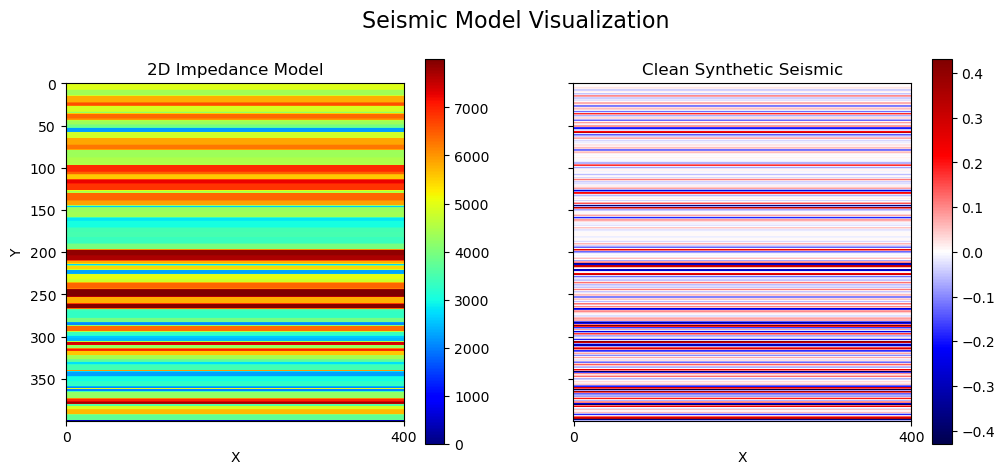

In [103]:
# Plotting all figures in a single combined plot
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
fig.suptitle("Seismic Model Visualization", fontsize=16)

# Plot the impedance model
im0 = axs[0].imshow(impedance_model, cmap='jet')
axs[0].set_title("2D Impedance Model")
axs[0].set_xlabel("X")
axs[0].set_ylabel("Y")
axs[0].set_xticks([0, 400])
plt.colorbar(im0, ax=axs[0])

# Plot the clean synthetic seismic array
im1 = axs[1].imshow(synthetic_init, cmap='seismic', vmax=amplitude_quantile, vmin=-amplitude_quantile)
axs[1].set_title("Clean Synthetic Seismic")
axs[1].set_xlabel("X")
axs[1].set_xticks([0, 400])
plt.colorbar(im1, ax=axs[1])

#plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for suptitle
plt.show()

In [123]:
def modelFault(model, random_horizontal_invert=False):
    """
    Apply a fault to a 2D seismic model.
    
    Parameters:
    - model: 2D numpy array representing the seismic model.
    - random_horizontal_invert: If True, may flip the model horizontally with 50% probability.
    
    Returns:
    - modelFaulted: Faulted model.
    - fault_displacement: The displacement applied.
    - faultType: 'Inverse' or 'Normal' fault type.
    """
    # Randomly select fault direction
    direction = np.random.choice(['up', 'down'])

    # Generate a random displacement magnitude (positive value)
    displacement_magnitude = np.random.randint(1, int(model.shape[0] * 0.2))

    # Set displacement direction and fault type
    if direction == 'up':
        fault_displacement = displacement_magnitude  # Positive displacement
        faultType = 'Inverse'
    else:
        fault_displacement = -displacement_magnitude  # Negative displacement
        faultType = 'Normal'

    # Create a copy of the model
    modelFaulted = model.copy()

    # Apply vertical shift
    shifted = sp.ndimage.shift(
        model,
        shift=(fault_displacement, 0),  # Apply vertical displacement
        cval=model[0, 0] * 0.9  # Fill shifted areas with a scaled background value
    )

    # Apply the shifted model back
    modelFaulted = shifted

    # Conditionally flip the model horizontally
    if random_horizontal_invert and np.random.rand() < 0.5:  # 50% chance to flip
        modelFaulted = np.fliplr(modelFaulted)

    return modelFaulted, fault_displacement, faultType, direction  # Return the direction for debugging

In [119]:
# # Randomly select between 'up' and 'down' fault directions
# fault_direction = np.random.choice(['up', 'down'])

In [124]:
# Apply fault to the synthetic seismic model
modelFaulted, fault_displacement, faultType, direction = modelFault(synthetic_init, random_horizontal_invert=True)

In [125]:
print(f"Direction chosen: {direction}")

Direction chosen: down


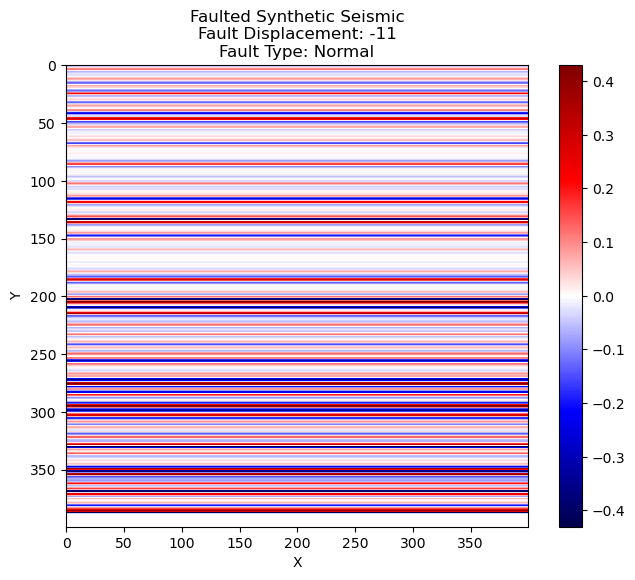

In [126]:

# Plot the faulted model
plt.figure(figsize=(8, 6))
plt.imshow(modelFaulted, cmap='seismic', vmax=amplitude_quantile, vmin=-amplitude_quantile)
plt.title(f"Faulted Synthetic Seismic\nFault Displacement: {fault_displacement}\nFault Type: {faultType}")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar()
plt.show()